In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_path = '/content/drive/MyDrive/Phase-4-project/train'
test_path = '/content/drive/MyDrive/Phase-4-project/test'
val_path = '/content/drive/MyDrive/Phase-4-project/val'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
image_height, image_width = 224, 224

# Create data generators with preprocessing and augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,             # Normalize pixel values to [0, 1]
    rotation_range=20,            # Random rotation
    width_shift_range=0.2,        # Random horizontal shift
    height_shift_range=0.2,       # Random vertical shift
    horizontal_flip=True,         # Random horizontal flip
    shear_range=0.2,              # Shear intensity
    zoom_range=0.2                # Random zoom

)
# Create data generators for validation and test data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [5]:
# Flow data from directories and apply preprocessing
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'  # Assuming binary classification (e.g., pneumonia vs. normal)
)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 4434 images belonging to 2 classes.
Found 798 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler

# Create a Sequential model (model4)
model4 = Sequential()

# Convolutional layers
model4.add(Conv2D(128, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(256, (3, 3), activation='relu'))
model4.add(MaxPooling2D((2, 2)))

# Flatten the output for the fully connected layers
model4.add(Flatten())

# Fully connected layers
model4.add(Dense(512, activation='relu'))

# Output layer
model4.add(Dense(1, activation='sigmoid'))

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    Adjust the learning rate based on the current epoch.
    """
    initial_lr = 0.001  # Initial learning rate
    if epoch < 5:
        return initial_lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return initial_lr * 0.1  # Reduce the learning rate by a factor of 10 after the 5th epoch

# Compile the model with a custom optimizer that uses the learning rate schedule
custom_optimizer = Adam(learning_rate=lr_schedule(0))
model4.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 256)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 746496)            0         
                                                                 
 dense (Dense)               (None, 512)               3

In [ ]:
# Define callbacks
# Save the best model during training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model4.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Define the number of epochs
epochs = 20

# Fit the model to the training data
history4 = model4.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[model_checkpoint, early_stopping]
)

## Important Note
Please note that in this notebook, as well as in others, you may observe that the preceding cell has not been executed. This is due to a specific reason.

Given that I had already trained the model before transferring it here, it was unnecessary to expend both computational resources and time on redundant training. Moreover, Google Colab's GPU has a time limit, and I encountered issues where it would frequently terminate during the training of certain models.

To address this challenge, I employed an effective albeit unconventional approach. I pickled the training history and saved it to my local drive, alongside storing the best-performing model. This strategy allows me to load both the pickle file containing the training history and the pre-trained model, enabling me to resume work promptly without the need for redundant training.

Here is the pickling:

In [ ]:
#Save the training history
import pickle
with open('history4.pkl', 'wb') as file:
    pickle.dump(history4.history, file)

Now let's load both the pickled history and the model.

In [8]:
import pickle
with open('/content/drive/MyDrive/history4.pkl', 'rb') as file:
    history4 = pickle.load(file)

In [9]:
from keras import models
best_model4 = models.load_model('/content/drive/MyDrive/best_model4.h5')


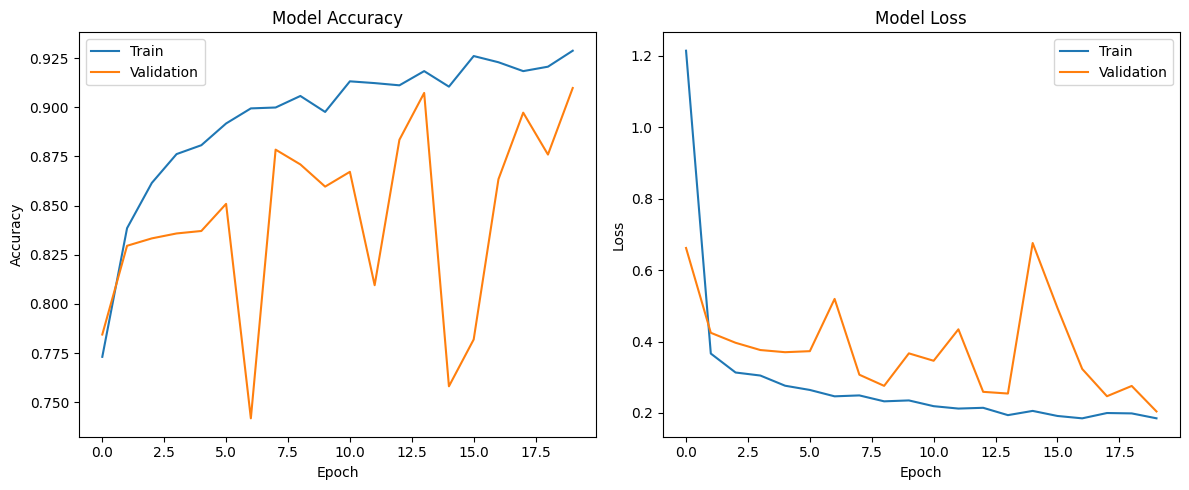

In [10]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history4['accuracy'])
plt.plot(history4['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history4['loss'])
plt.plot(history4['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
best_model4.evaluate(train_generator)

139/139 [==============================] - 1104s 8s/step - loss: 0.1862 - accuracy: 0.9272


[0.1862308531999588, 0.9271538257598877]

In [12]:
best_model4.evaluate(val_generator)

25/25 [==============================] - 182s 8s/step - loss: 0.2042 - accuracy: 0.9098


[0.20415884256362915, 0.9097744226455688]

In [13]:
best_model4.evaluate(test_generator)

20/20 [==============================] - 139s 7s/step - loss: 0.6116 - accuracy: 0.7708


[0.6116049289703369, 0.7708333134651184]